<a href="https://colab.research.google.com/github/hws2002/MachineLearning_PytorchNScikitLearn/blob/master/chapter3/chapter3_5_kernel_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Colab Notebooks/pyml/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

%load_ext autoreload
%autoreload 2

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/pyml


In [24]:
from utils.plot_decision_regions import plot_decision_boundary

# 3.5.1 선형적으로 구분되지 않는 데이터를 위한 커널 방법
SVM은 비선형 분류 문제를 풀기 위해 커널 방법을 사용할 수 있음.  
가장 널리 사용되는 SVM 방법인 **커널 SVM**(kernel SVM)의 주요 개념을 설명하기 전에 먼저 비선형 분류 문제가 어떤 모습인지 보기 위해 합성 데이터셋을 만들어보자

In [16]:
# 넘파이 logical_xor 함수를 사용하면 XOR형태의 간단한 데이터셋을 만들 ㅅ ㅜ있음.
np.random.seed(1)
X_xor = np.random.randn(200,2) # mean 0 and variance 1 normal distribution
# rng = np.random.default_rng(12345)
# X_xor = rng.normal(loc = 0.0, scale = 0.01, size = (200,2)) 와 같음
print("X_xor[:10,:] = " , X_xor[:10,:])
y_xor = np.logical_xor(X_xor[:,0] > 0, X_xor[:,1] > 0)
print("y_xor[:10] = ", y_xor[:10])
y_xor = np.where(y_xor, 1, 0)

X_xor[:10,:] =  [[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]
 [ 0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071]
 [-0.3224172  -0.38405435]
 [ 1.13376944 -1.09989127]
 [-0.17242821 -0.87785842]
 [ 0.04221375  0.58281521]]
y_xor[:10] =  [ True False  True  True  True  True False  True False False]


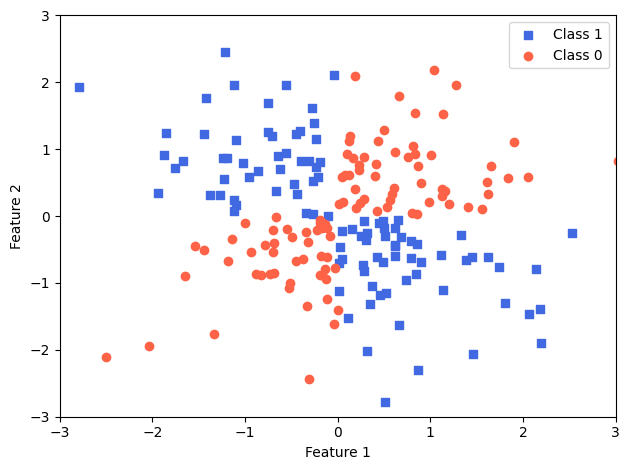

In [21]:
plt.scatter(X_xor[y_xor == 1,0], X_xor[y_xor == 1,1], c = 'royalblue', marker = 's', label = 'Class 1')
plt.scatter(X_xor[y_xor == 0,0], X_xor[y_xor == 0,1], c = 'tomato', marker = 'o', label = 'Class 0')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show();

## kernel method
양성클래스와 음성 클래스를 선형 초평면으로 구분할 수 없을 것 같다. (선형 로지스틱 회귀나 선형 SVM)  
이때 커널 방법(kernel method)를 쓰게 됨.  
기본 아이디어는 매핑 함수 $\phi$를 사용하여 원본 특성의 비선형 조합을 선형적으로 구분되는 고차원 공간에 투영하는 것임.  
고차원 공간에서 클래스를 구분하는 선형 초평면은 원본 특성 공간으로 되돌리면 비선형 결정 경계가 됨.  


# 3.5.2 커널 기법을 사용하여 고차원 공간에서 분할 초평면 찾기
매핑 함수를 사용하는 방식의 한 가지 문제점은 새로운 특성을 만드는 계산 손실이 매우 비싸다는 것임.(특히 고차원 데이터일때 더욱)  
그래서 ** 커널 기법 ** (kernel trick)이 등장하게 됨.  

## 커널 함수 kernel function

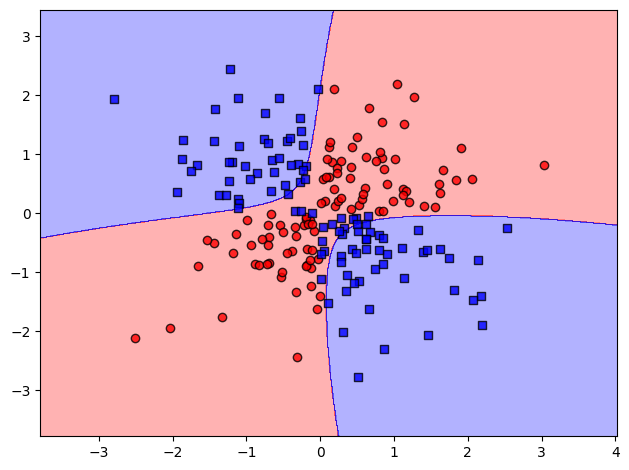

In [25]:
# 이제 커널 svm을 훈련하여 XOR 데이터를 구분하는 비선형 결정 경계를 그릴 수 있는지 알아보자.
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', random_state = 1, gamma = 0.10, C = 10.0)
svm.fit(X_xor, y_xor)
plot_decision_boundary(X_xor, y_xor, classifier = svm)
plt.tight_layout()
plt.show()

In [33]:
# load ,split, standardization
from utils.load_data import load_iris_from_skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X,y = load_iris_from_skl()
X = X[:,[2,3]]

X_train, X_test, y_train, y_test = train_test_split(
    X,y, random_state = 1, test_size = 0.3, shuffle = True, stratify = y
)

### check stratify
print("y lables : ", np.bincount(y))
print("y_train labels : ", np.bincount(y_train))
print("y_test labels : ", np.bincount(y_test))
print("y_train shape : ",y_train.shape)
print("y_test shape : ",y_test.shape)

###
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

y lables :  [50 50 50]
y_train labels :  [35 35 35]
y_test labels :  [15 15 15]
y_train shape :  (105,)
y_test shape :  (45,)


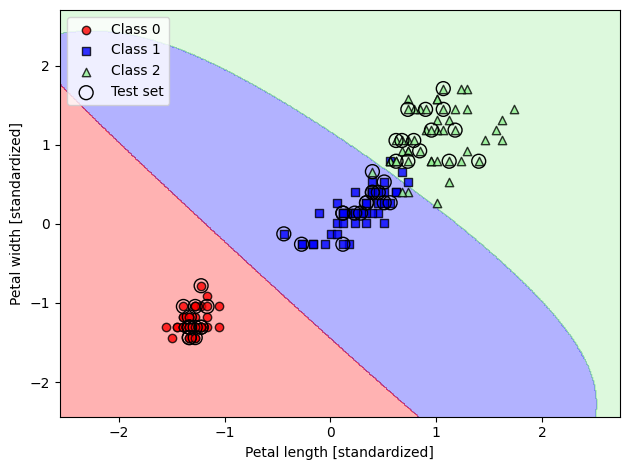

In [34]:

# gmma는 가우스 구(Gaussian shpere)의 크기를 제한하는 매개변수로 이해할 수 있음.
# 이 값이 크면 서포트 벡터의 영향이나 범위가 줄어듬 -> 결정 경계가 더욱 샘플에 가까워지고 구불구불해짐
svm = SVC(kernel = 'rbf', random_state = 1, gamma = 0.2, C = 1.0)

svm.fit(X_train_std, y_train)

plot_decision_boundary(X_combined_std, y_combined, classifier = svm, test_idx = range(105,150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

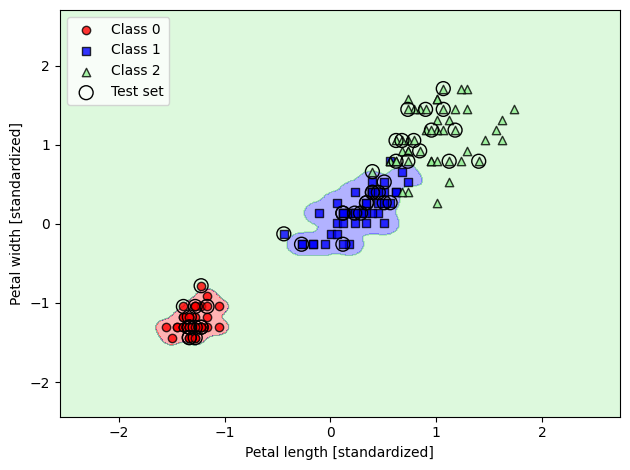

In [35]:

svm = SVC(kernel = 'rbf', random_state = 1, gamma = 100.0, C = 1.0)

svm.fit(X_train_std, y_train)

plot_decision_boundary(X_combined_std, y_combined, classifier = svm, test_idx = range(105,150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()